In [1]:
import os
from tempfile import NamedTemporaryFile

from lxml import etree
from lxml.builder import ElementMaker

import discoursegraphs as dg
from discoursegraphs.readwrite.rst.rs3 import extract_relationtypes, RSTTree

In [2]:
RS3TREE_DIR = os.path.join(dg.DATA_ROOT_DIR, 'rs3tree')
PCC_RS3_DIR = os.path.join(dg.DATA_ROOT_DIR,
                           'potsdam-commentary-corpus-2.0.0', 'rst')

def example2tree(rs3tree_example_filename, rs3tree_dir=RS3TREE_DIR, word_wrap=0, debug=False):
    """Given the filename of an rs3 file and its directory, return an RSTTree instance of it."""
    filepath = os.path.join(rs3tree_dir, rs3tree_example_filename)
    return RSTTree(filepath, word_wrap=word_wrap, debug=debug)

def printrs3(rs3tree_example_filename, rs3tree_dir=RS3TREE_DIR):
    filepath = os.path.join(rs3tree_dir, rs3tree_example_filename)
    with open(filepath) as rs3file:
        print(rs3file.read())

In [3]:
os.listdir(RS3TREE_DIR)

['eins-zwei-drei-(joint-eins-and-zwei-and-drei).rs3',
 'n-s-s-schema-eins-zwei-(joint-drei-vier)-plus-top-span.rs3',
 'only-one-segment.rs3',
 'eins-zwei-drei-(circ-(circ-eins-to-zwei)-from-drei).rs3',
 'foo-bar-only-segments.rs3',
 'foo-bar-circ-foo-to-bar.rs3',
 'foo-bar-circ-foo-to-bar-plus-top-span.rs3',
 'eins-zwei-drei-(circ-(joint-eins-and-zwei)-to-drei).rs3',
 'eins-zwei-drei-(elab-eins-from-(joint-zwei-and-drei).rs3',
 'maz-10207-excerpt.rs3',
 'maz-14654-excerpt.rs3',
 'schema-elab-elab.rs3',
 'maz-14813-excerpt.rs3',
 'foo-bar-foo-conj-bar.rs3',
 'maz-11279-excerpt.rs3',
 'eins-zwei-drei-(circ-eins-from-(joint-zwei-and-drei).rs3',
 'eins-zwei-drei-only-segments.rs3',
 'maz-6918-excerpt.rs3',
 'foo-bar-foo-joint-bar-plus-top-span.rs3',
 '.empty.rs3.swp',
 'eins-zwei-drei-(circ-(circ-eins-to-zwei)-to-drei.rs3',
 'n-s-s-schema-eins-zwei-(joint-drei-vier).rs3',
 'eins-zwei-drei-(circ-(joint-eins-and-zwei)-from-drei).rs3',
 'schema-elab-elab-plus-top-span.rs3',
 'eins-zwei-drei-(

# Task 1: create an empty rs3 file

In [4]:
dgtree = example2tree('empty.rs3')
dgtree

In [5]:
printrs3('empty.rs3')

<rst>
  <header>
    <relations>
    </relations>
  </header>
  <body>
  </body>
</rst>



In [6]:
E = ElementMaker()

def tree2rs3(dgtree, element_maker=E, debug=True):
    # create rs3 file skeleton
    tree = E('rst')

    header = E('header')
    relations = E('relations')
    add_relations(dgtree, relations)
    header.append(relations)

    body = add_body(dgtree)
    
    tree.append(header)
    tree.append(body)
    if debug is True:
        print(etree.tostring(tree, pretty_print=True))
    return tree

In [7]:
def add_relations(dgtree, relations_elem):
    for relname in sorted(dgtree.reltypes):
        # <rel name="circumstance" type="rst" />
        relations_elem.append(E('rel', name=relname, type=dgtree.reltypes[relname]))

In [8]:
def etree2file(rst_etree):
    """Returns file name of file containing lxml.etree._Element instance into a temporary file"""
    out_str = etree.tostring(rst_etree, pretty_print=True, encoding="UTF-8")
    temp_file = NamedTemporaryFile(delete=False)
    with open(temp_file.name, 'w') as outfile:
        outfile.write(out_str)
    return temp_file.name

In [9]:
def is_leaf(elem):
    return isinstance(elem, str)

def get_current_node_id(parent_id, node_ids):
    if parent_id is not None:
        node_id = parent_id + 1
    else:
        node_id = 1

    while node_id in node_ids:
        node_id += 1
    node_ids.add(node_id)
    return node_id

def add_body(dgtree, body=None, element_maker=E, num_indent=0, node_ids=None, parent_id=None):    
    if node_ids is None:
        node_ids = set()
    current_node_id = get_current_node_id(parent_id, node_ids)
    
    if body is None:
        body = E('body')

    if parent_id > 0:
        print('{indent}parent id: {parent_id}'.format(
            indent='\t'*num_indent, parent_id=parent_id))
        print('{0}parent label: {1}'.format(
            '\t'*num_indent, dgtree.parent().label()))

    print('{0}node id: {1}'.format(
        '\t'*num_indent, current_node_id))
    print('{0}node: {1}'.format(
        '\t'*num_indent, dgtree))
    print('{0}node label: {1}'.format(
        '\t'*num_indent, dgtree.label()))

    
#     <segment id="1">eins</segment>
#     <segment id="2" parent="4" relname="joint"> zwei</segment>
#     <segment id="3" parent="4" relname="joint"> drei</segment>
#     <group id="4" type="multinuc" parent="1" relname="elaboration" />

    for elem in dgtree:
        print('{indent}child: {node}'.format(indent='\t'*(num_indent+1), node=elem))
        
        if is_leaf(elem):
            leaf_id = get_current_node_id(current_node_id, node_ids)
            print('{0}child id: {1}'.format('\t'*(num_indent+1), leaf_id))
            if parent_id is None:
                body.append(E('segment', elem, id=str(leaf_id)))
            else:
                body.append(E('segment', elem, id=str(leaf_id),
                              parent=str(current_node_id), relname=dgtree.parent().label()))
        else:
            if parent_id is None:
#                 body.append(E('group'))
                pass
            add_body(elem, body=body, num_indent=num_indent+2,
                     node_ids=node_ids, parent_id=current_node_id)
    return body

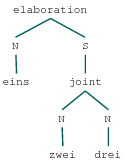

In [10]:
dgtree = example2tree('eins-zwei-drei-(elab-eins-from-(joint-zwei-and-drei).rs3')
dgtree

In [11]:
tree2rs3(dgtree)

node id: 1
node: (elaboration (N eins) (S (joint (N zwei) (N drei))))
node label: elaboration
	child: (N eins)
		parent id: 1
		parent label: elaboration
		node id: 2
		node: (N eins)
		node label: N
			child: eins
			child id: 3
	child: (S (joint (N zwei) (N drei)))
		parent id: 1
		parent label: elaboration
		node id: 4
		node: (S (joint (N zwei) (N drei)))
		node label: S
			child: (joint (N zwei) (N drei))
				parent id: 4
				parent label: S
				node id: 5
				node: (joint (N zwei) (N drei))
				node label: joint
					child: (N zwei)
						parent id: 5
						parent label: joint
						node id: 6
						node: (N zwei)
						node label: N
							child: zwei
							child id: 7
					child: (N drei)
						parent id: 5
						parent label: joint
						node id: 8
						node: (N drei)
						node label: N
							child: drei
							child id: 9
<rst>
  <header>
    <relations>
      <rel type="rst" name="elaboration"/>
      <rel type="multinuc" name="joint"/>
      <rel type="multinuc" name="v

<Element rst at 0x7faf629d4050>

In [12]:
res = tree2rs3(dgtree)

node id: 1
node: (elaboration (N eins) (S (joint (N zwei) (N drei))))
node label: elaboration
	child: (N eins)
		parent id: 1
		parent label: elaboration
		node id: 2
		node: (N eins)
		node label: N
			child: eins
			child id: 3
	child: (S (joint (N zwei) (N drei)))
		parent id: 1
		parent label: elaboration
		node id: 4
		node: (S (joint (N zwei) (N drei)))
		node label: S
			child: (joint (N zwei) (N drei))
				parent id: 4
				parent label: S
				node id: 5
				node: (joint (N zwei) (N drei))
				node label: joint
					child: (N zwei)
						parent id: 5
						parent label: joint
						node id: 6
						node: (N zwei)
						node label: N
							child: zwei
							child id: 7
					child: (N drei)
						parent id: 5
						parent label: joint
						node id: 8
						node: (N drei)
						node label: N
							child: drei
							child id: 9
<rst>
  <header>
    <relations>
      <rel type="rst" name="elaboration"/>
      <rel type="multinuc" name="joint"/>
      <rel type="multinuc" name="v

In [13]:
example2tree(etree2file(tree2rs3(example2tree('empty.rs3'), debug=False)))

node id: 1
node: ( )
node label: 


# Task 2: create rs3 file with one segment

In [14]:
example2tree('only-one-segment.rs3')

In [15]:
example2tree(etree2file(tree2rs3(example2tree('only-one-segment.rs3'), debug=False)))

node id: 1
node: (N foo)
node label: N
	child: foo
	child id: 2


In [16]:
printrs3('only-one-segment.rs3')

<rst>
  <header>
    <relations>
    </relations>
  </header>
  <body>
    <segment id="1">foo</segment>
  </body>
</rst>



# Task 3: create rs3 file with one relation

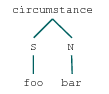

In [17]:
example2tree("foo-bar-circ-foo-to-bar.rs3")

In [18]:
example2tree(etree2file(tree2rs3(example2tree("foo-bar-circ-foo-to-bar.rs3"), debug=False)))

node id: 1
node: (circumstance (S foo) (N bar))
node label: circumstance
	child: (S foo)
		parent id: 1
		parent label: circumstance
		node id: 2
		node: (S foo)
		node label: S
			child: foo
			child id: 3
	child: (N bar)
		parent id: 1
		parent label: circumstance
		node id: 4
		node: (N bar)
		node label: N
			child: bar
			child id: 5


In [19]:
tree2rs3(example2tree("foo-bar-circ-foo-to-bar.rs3"))

node id: 1
node: (circumstance (S foo) (N bar))
node label: circumstance
	child: (S foo)
		parent id: 1
		parent label: circumstance
		node id: 2
		node: (S foo)
		node label: S
			child: foo
			child id: 3
	child: (N bar)
		parent id: 1
		parent label: circumstance
		node id: 4
		node: (N bar)
		node label: N
			child: bar
			child id: 5
<rst>
  <header>
    <relations>
      <rel type="rst" name="circumstance"/>
      <rel type="multinuc" name="conjunction"/>
      <rel type="multinuc" name="virtual-root"/>
    </relations>
  </header>
  <body>
    <segment relname="circumstance" id="3" parent="2">foo</segment>
    <segment relname="circumstance" id="5" parent="4">bar</segment>
  </body>
</rst>



<Element rst at 0x7faf62a09758>

In [20]:
printrs3("foo-bar-circ-foo-to-bar.rs3")

<rst>
  <header>
    <relations>
      <rel name="circumstance" type="rst" />
      <rel name="conjunction" type="multinuc" />
    </relations>
  </header>
  <body>
    <segment id="1" parent="2" relname="circumstance">foo</segment>
    <segment id="2"> bar</segment>
  </body>
</rst>



# Task 4: create rs3 file w/ nested tree

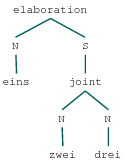

In [21]:
dgtree = example2tree('eins-zwei-drei-(elab-eins-from-(joint-zwei-and-drei).rs3')
dgtree

In [22]:
printrs3('eins-zwei-drei-(elab-eins-from-(joint-zwei-and-drei).rs3')

<rst>
  <header>
    <relations>
      <rel name="elaboration" type="rst" />
      <rel name="joint" type="multinuc" />
    </relations>
  </header>
  <body>
    <segment id="1">eins</segment>
    <segment id="2" parent="4" relname="joint"> zwei</segment>
    <segment id="3" parent="4" relname="joint"> drei</segment>
    <group id="4" type="multinuc" parent="1" relname="elaboration" />
  </body>
</rst>

